In [0]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim
import glob
import errno

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
path = '/home/dimitris/Desktop/NLP2/nips*/*.txt'
files = glob.glob(path)
data=[]
data2=[]
for name in files:
    try:
        with open(name, encoding = "ISO-8859-1") as f:
            data.append(str(f.readlines()))
    except IOError as exc:
        if exc.errno != errno.EISDIR:
            raise
print(len(data))

1740


In [0]:
# Remove new line characters
data = [re.sub('\s+', ' ', i) for i in data]

# Remove distracting single quotes
data = [re.sub("\'", "", i) for i in data]

In [0]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

I used Gensim's simple_preprocess() to tokenize each sentence into a list of words, removing punctuations and unnecessary characters all together.

In [0]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


/home/dimitris/.local/lib/python3.5/site-packages/msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
/home/dimitris/.local/lib/python3.5/site-packages/msgpack_numpy.py:88: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr))[0]
/home/dimitris/.local/lib/python3.5/site-packages/msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
/home/dimitris/.local/lib/python3.5/site-packages/msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
/home/di

Lemmatization is a process where we convert words to its root word. The advantage of this is, we get to reduce the total number of unique words in the dictionary. As a result, the number of columns in the document-word matrix (created by CountVectorizer in the next step) will be denser with lesser columns.

In [0]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

The LDA topic model algorithm requires a document word matrix as the main input. I can create one using CountVectorizer. In the above code, I have configured the CountVectorizer to consider words that has occurred at least 10 times (min_df), remove built-in english stopwords, convert all words to lowercase, and a word can contain numbers and alphabets of at least length 3 in order to be qualified as a word.

In [0]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  6.06407811506758 %


Sparsicity is nothing but the percentage of non-zero datapoints in the document-word matrix, that is data_vectorized.

Since most cells in this matrix will be zero, I am interested in knowing what percentage of cells contain non-zero values.

In [0]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_topics=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

/home/dimitris/.local/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=20, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


In [0]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -16651990.274230022
Perplexity:  1273.3383651667725
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'n_topics': 20,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


A model with higher log-likelihood and lower perplexity (exp(-1. * log-likelihood per word)) is considered to be good.

In [0]:
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

/home/dimitris/.local/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/home/dimitris/.local/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/home/dimitris/.local/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/home/dimitris/.local/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_components': [10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

The most important tuning parameter for LDA models is n_components (number of topics). In addition, I am going to search learning_decay (which controls the learning rate) as well. Besides these, other possible search params could be learning_offset (downweigh early iterations. Should be > 1) and max_iter

In [0]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 15}
Best Log Likelihood Score:  -5738168.065875094
Model Perplexity:  1269.6520923465016


/home/dimitris/.local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/home/dimitris/.local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/home/dimitris/.local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


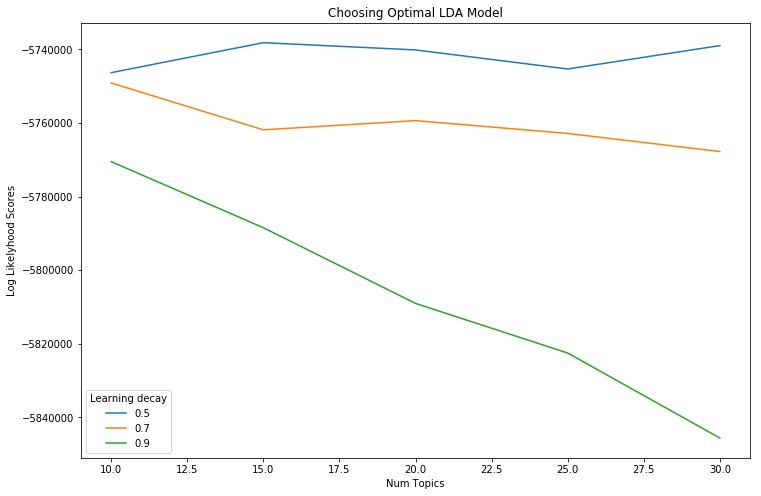

In [0]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [10, 15, 20, 25, 30]
log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.5]
log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.7]
log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

Plotting the log-likelihood scores against num_topics, clearly shows number of topics = 15 has better scores. And learning_decay of 0.5 outperforms both 0.7 and 0.9.

In [0]:
print(best_lda_model)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.5, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=15, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)


In [0]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,dominant_topic
Doc0,0.04,0.28,0.04,0.11,0.34,0,0,0,0.05,0,0,0.12,0,0.02,0,4
Doc1,0.02,0,0,0.17,0.32,0,0,0,0,0,0,0.46,0.01,0,0.02,11
Doc2,0,0,0,0,0.27,0.01,0.07,0.03,0,0,0,0.6,0.03,0,0,11
Doc3,0,0,0.01,0,0,0.11,0,0,0.6,0,0.29,0,0,0,0,8
Doc4,0.32,0.01,0.08,0.1,0.01,0.02,0,0.02,0.25,0.01,0.05,0.01,0,0.09,0.03,0
Doc5,0,0.01,0.01,0,0,0.14,0,0,0.02,0.01,0.52,0,0,0.16,0.13,10
Doc6,0,0.01,0.05,0.83,0,0,0,0,0,0,0,0.11,0,0,0,3
Doc7,0.23,0,0.1,0.24,0,0.04,0,0.18,0,0,0.04,0,0,0.1,0.07,3
Doc8,0,0.04,0.2,0,0,0,0,0.15,0,0,0.42,0,0,0.17,0.02,10
Doc9,0.22,0,0.01,0.1,0,0.1,0,0.02,0,0.02,0.42,0,0,0.11,0,10


To classify a document as belonging to a particular topic, a logical approach is to see which topic has the highest contribution to that document and assign it.

In the table above, I’ve greened out all major topics in a document and assigned the most dominant topic in its own column

In [0]:
i=0
for column in df_document_topic:
    if i<15:
        print("topic"+str(i)+": "+df_document_topic[column].idxmax()+" score: "+str(df_document_topic[column].max()))
    i=i+1

topic0: Doc909 score: 0.81
topic1: Doc1269 score: 0.73
topic2: Doc55 score: 0.73
topic3: Doc6 score: 0.83
topic4: Doc682 score: 0.81
topic5: Doc200 score: 0.92
topic6: Doc140 score: 0.67
topic7: Doc222 score: 0.85
topic8: Doc802 score: 0.86
topic9: Doc309 score: 0.83
topic10: Doc856 score: 0.88
topic11: Doc857 score: 0.91
topic12: Doc382 score: 0.91
topic13: Doc1086 score: 0.82
topic14: Doc1592 score: 0.89


The table above show us the most representative document for each topic with the score.

In [0]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,12,228
1,11,187
2,10,174
3,5,153
4,8,137
5,9,119
6,3,117
7,14,113
8,13,98
9,0,95


In [0]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

/home/dimitris/.local/lib/python3.5/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
12     11.691037        1       1  -29.991568 -117.519745
10     11.356179        1       2   92.314934   75.170776
5       9.575672        1       3 -100.331650  234.991211
11      8.355887        1       4 -111.293663  -14.862153
8       7.389305        1       5  -65.566635 -264.953857
13      7.009004        1       6   54.473034  229.525604
0       6.435124        1       7  215.537613 -138.370529
3       6.325037        1       8 -265.539673  -23.588692
14      6.304540        1       9  237.599121   14.057081
9       5.533630        1      10  -37.388767   91.640434
4       5.126634        1      11   87.996742 -222.759598
1       4.521954        1      12  205.494781  173.335327
7       4.187092        1      13 -185.238556 -159.360992
2       4.117441        1      14 -199.637070  118.088379
6       2.071465        1      15   83.378815  -54.666111, topic_info=     Category          Freq         Term         Total  loglift  logprob
term                                                                    
4573  Default  31444.000000      network  31444.000000  30.0000  30.0000
3250  Default   6913.000000        image   6913.000000  29.0000  29.0000
4598  Default   8556.000000       neuron   8556.000000  28.0000  28.0000
6565  Default  10571.000000        state  10571.000000  27.0000  27.0000
7314  Default  11712.000000         unit  11712.000000  26.0000  26.0000
6284  Default   5267.000000       signal   5267.000000  25.0000  25.0000
4361  Default  23368.000000        model  23368.000000  24.0000  24.0000
2765  Default  17363.000000     function  17363.000000  23.0000  23.0000
3856  Default  14236.000000        learn  14236.000000  22.0000  22.0000
7036  Default  13657.000000         time  13657.000000  21.0000  21.0000
935   Default   5983.000000         cell   5983.000000  20.0000  20.0000
7584  Default  10780.000000       weight  10780.000000  19.0000  19.0000
3432  Default  16907.000000        input  16907.000000  18.0000  18.0000
7127  Default   9973.000000     training   9973.000000  17.0000  17.0000
4881  Default  10974.000000       output  10974.000000  16.0000  16.0000
4715  Default   3448.000000       object   3448.000000  15.0000  15.0000
1392  Default   4926.000000      control   4926.000000  14.0000  14.0000
2516  Default   2466.000000       filter   2466.000000  13.0000  13.0000
7496  Default   3310.000000       visual   3310.000000  12.0000  12.0000
4643  Default   4921.000000        noise   4921.000000  11.0000  11.0000
5383  Default   6350.000000  probability   6350.000000  10.0000  10.0000
5662  Default   4249.000000  recognition   4249.000000   9.0000   9.0000
4236  Default   3358.000000       memory   3358.000000   8.0000   8.0000
1602  Default  11158.000000        datum  11158.000000   7.0000   7.0000
7434  Default   7730.000000       vector   7730.000000   6.0000   6.0000
2501  Default   4483.000000        field   4483.000000   5.0000   5.0000
4579  Default  15452.000000       neural  15452.000000   4.0000   4.0000
196   Default  12416.000000    algorithm  12416.000000   3.0000   3.0000
1039  Default   2546.000000      circuit   2546.000000   2.0000   2.0000
3860  Default   8861.000000     learning   8861.000000   1.0000   1.0000
...       ...           ...          ...           ...      ...      ...
6454  Topic15   1254.205841       source   1852.886553   3.4867  -3.6498
6926  Topic15    420.320945     template    576.235788   3.5614  -4.7431
6182  Topic15    457.293803   separation    665.660015   3.5015  -4.6588
6284  Topic15   2857.759794       signal   5267.061602   3.2655  -2.8263
973   Topic15    897.103018      channel   1523.886225   3.3471  -3.9849
3299  Topic15    204.428452      impulse    309.065334   3.4636  -5.4639
565   Topic15    245.578075         band    394.365907   3.4033  -5.2805
2704  Topic15   1023.882331    frequency   2398.900

The pyLDAvis offers the best visualization to view the topics-keywords distribution.

A good topic model will have non-overlapping, fairly big sized blobs for each topic. This seems to be the case here. So, we are good.

In [0]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,aaa,aaai,abandon,abbott,abbreviate,abele,ability,abl,able,ablex,...,zipset,zisserman,zky,zlx,zone,zoo,zornetzer,zoubin,zucker,zurich
Topic0,0.066667,3.019262,4.778399,0.066667,11.082656,0.066667,26.827206,27.513487,71.908964,0.066667,...,0.066667,0.066667,0.950098,0.067943,0.066667,0.066667,0.066667,84.162414,0.066667,0.066667
Topic1,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,33.684625,0.066668,59.510574,0.066667,...,0.066667,15.865902,0.066667,0.066667,0.066710,0.066667,0.066667,0.066667,0.066667,1.333703
Topic2,0.066667,0.066667,0.066667,0.068941,0.066667,0.066667,41.554466,0.066667,32.644312,0.066667,...,0.066667,0.066667,0.066667,0.066667,3.487532,0.066667,0.066667,0.066667,0.066667,0.066667
Topic3,0.066668,0.066667,2.403409,0.066667,0.066667,0.066667,87.558708,0.897483,53.940313,0.066667,...,0.066667,0.066667,0.066667,0.066667,0.066667,3.556968,0.066667,0.066667,0.066667,0.066667
Topic4,0.066667,0.066667,0.066668,1.434599,0.066668,0.066667,83.173554,0.066667,54.782796,5.864782,...,8.711495,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,12.551589,0.066667


The weights of each keyword in each topic is contained in lda_model.components_ as a 2d array. The names of the keywords itself can be obtained from vectorizer object using get_feature_names().

Let’s use this info to construct a weight matrix for all keywords in each topic.

In [0]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,state,model,probability,algorithm,sequence,use,markov,structure,variable,node,parameter,distribution,transition,tree,level
Topic 1,image,use,figure,pixel,motion,output,edge,vision,scale,feature,line,filter,field,scene,intensity
Topic 2,network,memory,neural,circuit,analog,chip,neuron,input,output,use,current,weight,time,voltage,figure
Topic 3,network,time,neural,dynamic,equation,state,model,parameter,point,order,result,function,nonlinear,fix,solution
Topic 4,model,object,visual,field,direction,orientation,eye,unit,receptive,stimulus,map,motion,figure,feature,position
Topic 5,use,set,training,algorithm,datum,classifier,class,performance,test,classification,problem,network,example,learn,number
Topic 6,signal,filter,source,time,frequency,channel,use,detection,component,noise,spectral,separation,template,correlation,analysis
Topic 7,neuron,spike,information,input,noise,pattern,code,network,rate,time,probability,output,value,neural,distribution
Topic 8,network,recognition,use,word,speech,feature,input,training,neural,representation,train,set,context,output,character
Topic 9,learn,state,control,learning,action,use,time,model,value,policy,reinforcement,task,controller,trajectory,dynamic
